In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
from malaya_speech.torch_model.vits.model_infer import SynthesizerTrn
from malaya_boilerplate.train.config import HParams
import json

`pyaudio` is not available, `malaya_speech.streaming.stream` is not able to use.


In [3]:
config = '/home/husein/malay_vits/ms-MY-Wavenet-C.json'

In [4]:
with open(config) as fopen:
    hps = HParams(**json.load(fopen))

In [5]:
from malaya_speech.utils.text import TTS_SYMBOLS
import torch

In [6]:
model = SynthesizerTrn(len(TTS_SYMBOLS),
                                   hps.data.filter_length // 2 + 1,
                                   hps.train.segment_size // hps.data.hop_length,
                                   **hps.model)

In [7]:
_ = model.eval()

In [29]:
!ls /home/husein/malay_vits/logs/ms-MY-Wavenet-C/G_*.pth

/home/husein/malay_vits/logs/ms-MY-Wavenet-C/G_600000.pth
/home/husein/malay_vits/logs/ms-MY-Wavenet-C/G_605000.pth
/home/husein/malay_vits/logs/ms-MY-Wavenet-C/G_610000.pth


In [30]:
pth = '/home/husein/malay_vits/logs/ms-MY-Wavenet-C/G_610000.pth'

In [31]:
model.load_state_dict(torch.load(pth, map_location=torch.device('cpu'))['model'])

<All keys matched successfully>

In [11]:
from malaya_speech.torch_model.vits.commons import intersperse
import malaya_speech

In [12]:
normalizer = malaya_speech.utils.text.TextIDS(pad_to = None, is_lower = False)

In [32]:
text = 'Haqkiem adalah pelajar tahun akhir yang mengambil Ijazah Sarjana Muda Sains Komputer Kecerdasan Buatan utama dari Universiti Teknikal Malaysia Melaka (UTeM) yang kini berusaha untuk latihan industri di mana dia secara praktikal dapat menerapkan pengetahuannya dalam Perisikan Perisian dan Pengaturcaraan ke arah organisasi atau industri yang berkaitan.'

In [38]:
text = """
SHAH ALAM - Pertubuhan Kebajikan Anak Bersatu Selangor (PKABS) bersetuju pihak kerajaan mewujudkan Suruhanjaya Siasatan Diraja (RCI) untuk menyiasat isu kartel daging.
"""

In [39]:
t, ids = normalizer.normalize(text)
t


'SHAH ALAM - Pertubuhan Kebajikan Anak Bersatu Selangor , PKABS , bersetuju pihak kerajaan mewujudkan Suruhanjaya Siasatan Diraja , RCI , untuk menyiasat isu kartel daging .'

In [40]:
ids = intersperse(ids, 0)
ids = torch.LongTensor(ids)
ids_lengths = torch.LongTensor([ids.size(0)])
ids = ids.unsqueeze(0)
audio = model.infer(
    ids,
    ids_lengths,
    noise_scale=0.66666,
    noise_scale_w=0.66666,
    length_scale=1.0,
)

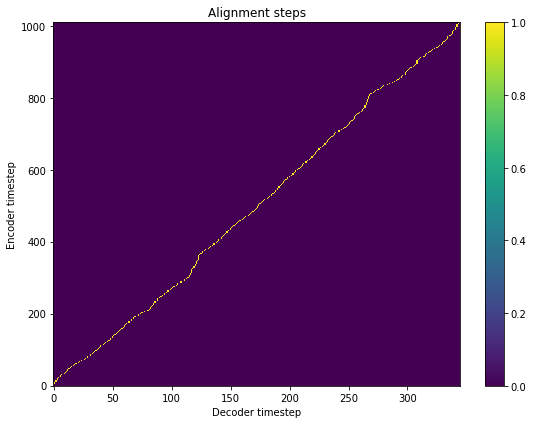

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    audio[1][0,0].detach().numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [42]:
y = audio[0][0,0].detach().numpy()

In [43]:
import IPython.display as ipd
ipd.Audio(y, rate = 22050)

In [44]:
torch.save(model.state_dict(), 'bunga.pth')

In [45]:
from malaya_boilerplate.huggingface import upload_dict

In [46]:
files_mapping = {'bunga.pth': 'model.pth',
                config: 'config.json'}
upload_dict(model = 'VITS-bunga', files_mapping = files_mapping, username = 'mesolitica')

<class 'requests.exceptions.HTTPError'> (Request ID: Root=1-63de361d-30d5652f10536cbd5533b059)

You already created this model repo - You already created this model repo


In [24]:
!mkdir pretrained-bunga
!rm pretrained-bunga/*.pth

mkdir: cannot create directory ‘pretrained-bunga’: File exists
rm: cannot remove 'pretrained-bunga/*.pth': No such file or directory


In [25]:
!cp ~/malay_vits/logs/ms-MY-Wavenet-C/*_540000.pth pretrained-bunga
!cp ~/malay_vits/logs/ms-MY-Wavenet-C/config.json pretrained-bunga
!cp ~/malay_vits/logs/ms-MY-Wavenet-C/events.out* pretrained-bunga

In [26]:
!ls -lh pretrained-bunga

total 1.3G
-rw-r--r-- 1 husein husein 1.4K Feb   4 10:12 config.json
-rw-r--r-- 1 husein husein 536M Feb   4 10:12 D_540000.pth
-rw-r--r-- 1 husein husein   40 Feb   4 10:12 events.out.tfevents.1675238286.husein-MS-7D31.3032017.0
-rw-r--r-- 1 husein husein   40 Feb   4 10:12 events.out.tfevents.1675238322.husein-MS-7D31.3033066.0
-rw-r--r-- 1 husein husein   40 Feb   4 10:12 events.out.tfevents.1675238351.husein-MS-7D31.3033994.0
-rw-r--r-- 1 husein husein 348M Feb   4 10:12 events.out.tfevents.1675238383.husein-MS-7D31.3034934.0
-rw-r--r-- 1 husein husein 417M Feb   4 10:12 G_540000.pth


In [27]:
!tar -cvf pretrained-bunga.tar pretrained-bunga

pretrained-bunga/
pretrained-bunga/G_540000.pth
pretrained-bunga/config.json
pretrained-bunga/D_540000.pth
pretrained-bunga/events.out.tfevents.1675238322.husein-MS-7D31.3033066.0
pretrained-bunga/events.out.tfevents.1675238383.husein-MS-7D31.3034934.0
pretrained-bunga/events.out.tfevents.1675238351.husein-MS-7D31.3033994.0
pretrained-bunga/events.out.tfevents.1675238286.husein-MS-7D31.3032017.0


In [28]:
files_mapping = {'pretrained-bunga.tar': 'pretrained-bunga.tar'}
upload_dict(model = 'VITS-bunga', files_mapping = files_mapping, username = 'mesolitica')

<class 'requests.exceptions.HTTPError'> (Request ID: Root=1-63ddbf31-686f14bb39952f973f71c9da)

You already created this model repo - You already created this model repo
